# A/B Testing


**A/B Testing** adalah model untuk menentukan apakah keputusan 1 lebih baik daripada keputusan 2, atau sebaliknya. Pada Kasus ini, dilakukan A/B testing terhadap sebuah website e-commerce. A/B Testing ini melihat apakah versi website yang baru dapat lebih meningkatkan converted rate dari user. Hasil dari A/B Testing tersebut telah disimpan dalam file `ab_testing.csv`. Kemudian dilakukan analisis untuk membantu perusahaan memahami apakah mereka harus mengimplementasikan strategi, mempertahankan versi website lama, atau mungkin menjalankan eksperimen lebih lama untuk membuat keputusan lainnya.

### Studi Kasus:

Pada data ini terdapat beberapa `segmentasi` (diambil dari version) yang dijadikan bahan penelitian, diantaranya adalah
    1. A1
    2. A2
    3. B
    4. C

> Studi kasus ini mengambil nilai konversi dari **clicked** menjadi **liked** dan melihat hubungan antara versi website yang mereka gunakan, apakah terdapat perbedaan atau tidak? Apakah kesimpulan yang bisa ditarik dari data kita? Dan bagaimana mengambil keputusan terkait hasil tersebut nantinya?

---

### Import Modules

In [294]:
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare

import math
import scipy.stats as stats

import seaborn as sns
sns.set(color_codes=True)

#from datetime import datetime
from datetime import timedelta
import datetime
import time
import os

---

# Sample Size
Dalam menentukan sample size, kita bisa *running* beberapa test terhadap model. Namun, untuk mempermudah perkiraan sample size yang cocok, kita bisa lihat atau akses pranala berikut ini [EvanMiller Calculation](https://www.evanmiller.org/ab-testing/sample-size.html). Dibawah ini terdapat perkiraan *sample size* yang tidak jauh berbeda dengan perhitungan pada EvanMiller Calculation.

### 1. Menentukan Variable Penelitian 

In [295]:
# Apakah kita ingin melakukan one sided atau two sided test? Pada model kali ini, kita menggunakan one sided test.
one_sided = True 

# Penentuan sample size untuk data test dari A/B Testing kita
baseline_prob = 0.08
beta = 0.2
alpha = 0.05
eff = 0.015

#### Berdasarkan penentuan variabel di atas, kita definisikan setiap variabel kita sebagai berikut,

In [296]:
alpha_Zscore = stats.norm.ppf(1-alpha*(1-0.5*(1-one_sided)))
beta_Zscore = stats.norm.ppf(1-beta)

print('Nilai Baseline Conversion (prob) = ', baseline_prob*100, '%')
print('Tingkat Confidence Level = ', (1-alpha)*100, '%')
print('Alpha Z-score (zalp) = ', round(alpha_Zscore,2))
print('Beta Z-score (zbet) = ', round(beta_Zscore,2))
print('Power = ', (1-beta)*100, '%')
print('Nilai Effect Size (E) = ', eff*100, '%')

Nilai Baseline Conversion (prob) =  8.0 %
Tingkat Confidence Level =  95.0 %
Alpha Z-score (zalp) =  1.64
Beta Z-score (zbet) =  0.84
Power =  80.0 %
Nilai Effect Size (E) =  1.5 %


#### Per Sample Traffic

In [297]:
def sample_size(E, zalp, zbet, prob):
    variance = prob*(1-prob)  # largest when pr = 0.5, use when you don't have any baseline estimate
    z = (zalp+zbet)**2
    top = 2*variance*z
    bottom = E**2
    n = top/bottom
    return n

n = sample_size(eff, alpha_Zscore, beta_Zscore, baseline_prob)
print('Jumlah ukuran untuk sample size (per variation)nya adalah',round(n,0))

Jumlah ukuran untuk sample size (per variation)nya adalah 4045.0


## Menentukan Minimum Detectable Effect
- Diketahui nilai alpha, beta, dan sample size dari model kita, apakah kita dapat mengetahui terjadi perbedaan atau tidak dari sample test kita dalam ukuran (size) sebesar itu (detectable effect)?
- Untuk memastikan effect size model kita, dapat dilakukan perhitungan effect terhadap sample size (n)

In [298]:
# Mendefinisikan rumus yang akan menggunakan sample size dan mengabaikan effect size.
# Kalau model sebelumnya (def sample_size) menggunakan "eff", kali ini tidak ada, karena kita ingin mencari effect size yg tepat

def measurable_eff(n, zalp, zbet, prob):
    variance = prob*(1-prob)  # Ketika tidak ada baseline, gunakan prob = 0.5
    z = (zalp+zbet)**2
    top = 2*variance*z
    bottom = n
    E = math.sqrt(top/n)
    return E

# What is the current minimal detectable effect size? (Seharusnya sama dengan effect size yang didefinisikan di atas, yaitu 1.5%)
measurable_eff(n, alpha_Zscore, beta_Zscore, baseline_prob)

0.015

---

## 3. Import Dataset 

In [299]:
file_name = 'ABData.csv'
date_sort = 'date_visit' # mengurutkan date_visit

# Update the column where the date is stored in the converters section below, if no such column, remove the conversion
data = pd.read_csv('/Users/andimu064127/Use Case - Marketing Analysis/Dataset/' + file_name,
                  converters= {date_sort: pd.to_datetime} )
d2 = data.copy()
d2 = d2.sort_values(date_sort, ascending = True)

# Variabel yang diambil untuk perhitungan conversion rate.
traffic_label = 'clicked'
conv_label = 'liked'

# Grouping column names
user_label = 'user_id'
date_label = 'date_visit'
segment_label = 'version'


d2.head()

,user_id,date_joined,date_visit,version,type,category,visits,clicked,clicks,liked,likes
0,31098458,2018-04-23,2018-04-23,B,0,E,3,0,0,0,0
313,31098587,2018-04-27,2018-04-23,C,1,M,1,1,1,1,8
312,31098584,2018-04-27,2018-04-23,A1,1,NaN,1,1,1,0,0
311,31098582,2018-04-27,2018-04-23,B,1,E,1,1,1,1,7
310,31098581,2018-04-27,2018-04-23,A2,0,NaN,1,1,2,1,5


In [300]:
# List of names of unique names of the segments
segment_list = list(d2[segment_label].unique())
segment_list

['B', 'C', 'A1', 'A2']

#### Segment Summary

In [301]:
# Jumlah variasi segmentasi
variations = len(segment_list)

# Verifikasi segmen penelitian kita
print('Kumpulan Segmentasi: ',segment_list)
print('Jumlah   Segmentasi: ', variations)

Kumpulan Segmentasi:  ['B', 'C', 'A1', 'A2']
Jumlah   Segmentasi:  4


## 4. Data Analysis

### 4.1 Penggunaan Harian User

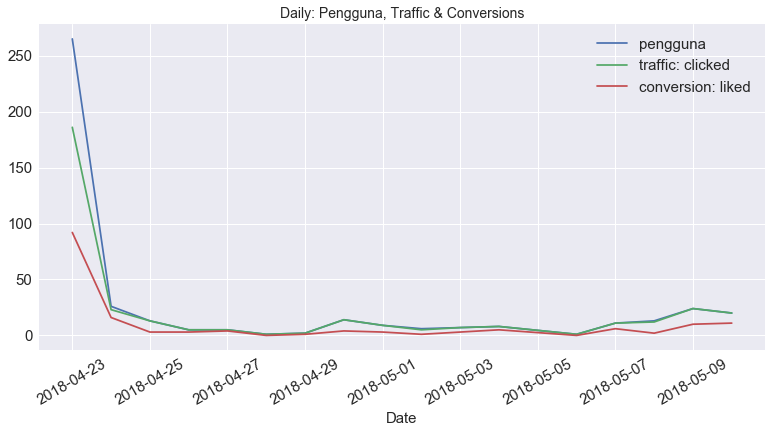

In [302]:
# Agregasi data terhadap hari (date) pada dataset
daily_users = pd.DataFrame(d2.groupby(date_label)[user_label].nunique()).reset_index()
daily_traffic = pd.DataFrame(d2.groupby(date_label)[traffic_label].sum()).reset_index()
daily_conversions = pd.DataFrame(d2.groupby(date_label)[conversion_label].sum()).reset_index()



plt.subplots(figsize=(13, 6))
plt.plot(pd.to_datetime(daily_users[date_label]), daily_users[user_label], label = 'pengguna')
plt.plot(pd.to_datetime(daily_traffic[date_label]), daily_traffic[traffic_label], label = ('traffic: ' + traffic_label))
plt.plot(pd.to_datetime(daily_conversions[date_label]), daily_conversions[conversion_label], label = ('conversion: ' + conversion_label))


plt.xlabel('Date', fontsize=15)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
plt.title('Daily: Pengguna, Traffic & Conversions', fontsize=14)
plt.legend(fontsize=15)
plt.show()

### 4.2 Overall Conversion Rate

In [303]:
round((daily_conversions[conversion_label]/daily_traffic[traffic_label]).mean()*100,2)

40.43

### 4.3 Average Overall Traffic per User

In [304]:
round((daily_traffic[traffic_label]/daily_users[user_label]).mean(),3)

0.961

### 4.4 Average Overall Conversions per User

In [305]:
round((daily_conversions[conversion_label]/daily_users[user_label]).mean(),3)

0.388

### 4.5 Daily Segment Volatility Chart

In [306]:
color_hex_list = ['#88CCEE', '#CC6677', '#DDCC77', '#117733', '#332288', '#E58606',  '#999933', '#882255', '#661100', 
 '#5D69B1', '#52BCA3', '#99C945', '#CC61B0', '#24796C', '#DAA51B', '#2F8AC4', '#764E9F', '#ED645A']

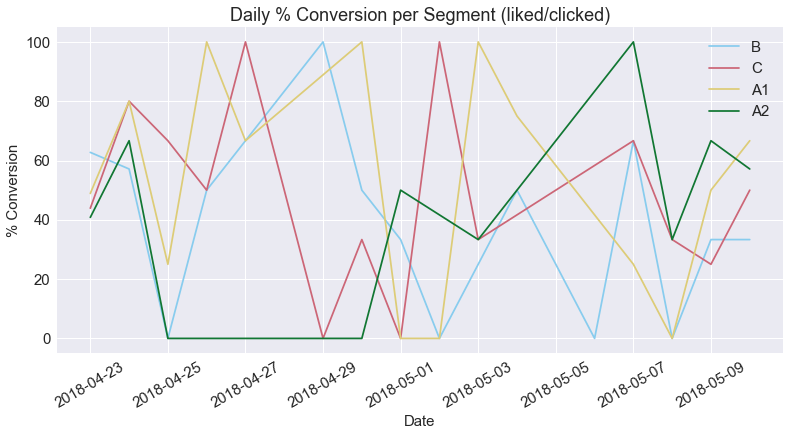

In [307]:
# Group data by day
daily_segment_traffic = pd.DataFrame(d2.groupby([date_label, segment_label])[traffic_label].sum()).reset_index()
daily_segment_conversions = pd.DataFrame(d2.groupby([date_label, segment_label])[conversion_label].sum()).reset_index()

daily_segment_conv_rate = pd.merge(daily_segment_traffic, daily_segment_conversions, on = [date_label, segment_label], how = 'left')
daily_segment_conv_rate['conversion_rate'] = 100*daily_segment_conv_rate[conversion_label]/daily_segment_conv_rate[traffic_label] 


# Plot Figures
plt.subplots(figsize=(13, 6))

for i in range(0, variations):
    df = daily_segment_conv_rate[daily_segment_conv_rate[segment_label] == segment_list[i] ]
    plt.plot(pd.to_datetime(df[date_label]), df['conversion_rate'], label = segment_list[i], color= color_hex_list[i])

# Chart Labels and Font Size
plt.xlabel('Date', fontsize=15)
plt.ylabel('% Conversion', fontsize=15)

plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
chart_title = 'Daily % Conversion per Segment ({}/{})'.format(conversion_label, traffic_label)
plt.title(chart_title, fontsize=18)
plt.legend(fontsize=15)
plt.show()

### 4.6 Create Simplified Table

In [308]:
# Create a loop to aggregate the traffic and conversion for each segment.

# Specify the 'traffic' column and the 'conversion' column 
aggregation_column = [traffic_label, conversion_label]

# Create empty lists to populate in the loop below
traffic = []
conversions = [] 

# This table will the underlying table used in the subsequent sections to analyze the test results.
for i in range(variations):
    v, c = d2[d2[segment_label] == segment_list[i] ][aggregation_column[:2]].sum()

    traffic.append(v)
    conversions.append(c)
    
    
# Create a Simple Data Frame for Proportions (from the above lists)   
dfp_simple = pd.DataFrame({
    "converted": conversions,
    "traffic": traffic
}, index = segment_list)

dfp_simple

,converted,traffic
B,48,92
C,37,80
A1,42,86
A2,37,88


### 4.7 Menambahkan Index dan/atau Kolom Penelitan

In [309]:
dfp = dfp_simple.copy().sort_index()

# Menjumlahkan keseluruhan kolom
dfp.loc['Total'] = dfp.sum()

# Yang tidak berubah (not conververted) adalah traffic dikurangi dengan converted
dfp['not_converted'] = dfp['traffic'] - dfp['converted']

# Proporsi dari konversi setiap segmennya
proportion = dfp.converted/dfp.traffic
dfp['converted_proportion'] = proportion

# Standard Error
dfp['standard_error'] = ((proportion * (1-proportion))/dfp.traffic)**(.5)

# Persentasi traffic dari total user yang menggunakan website
n = dfp.loc['Total']['traffic']
dfp['population_percentage'] = dfp['traffic']/n

dfp

,converted,traffic,not_converted,converted_proportion,standard_error,population_percentage
A1,42,86,44,0.488372,0.053902,0.248555
A2,37,88,51,0.420455,0.052621,0.254335
B,48,92,44,0.521739,0.052079,0.265896
C,37,80,43,0.462500,0.055744,0.231214
Total,164,346,182,0.473988,0.026844,1.000000


### 4.8 Plot the Conversion Rates

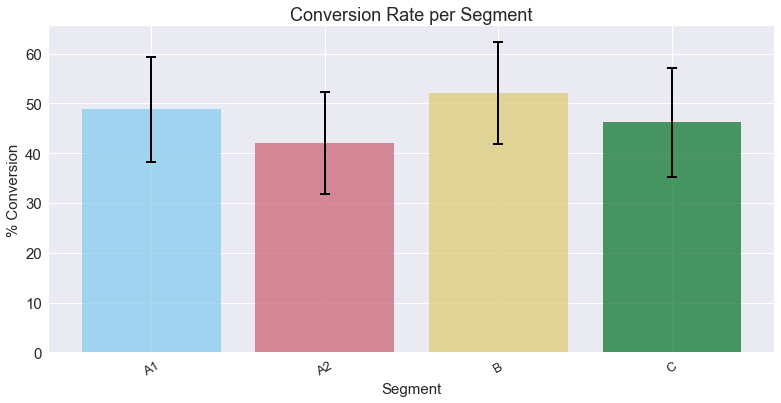

In [310]:
# Bar Plot Inputs
labels = dfp.index[:-1].tolist()
label_index = np.arange(len(labels))
values = (round(dfp['converted_proportion'][:-1]*100,2)).tolist()
half_ci = (round(dfp['standard_error'][:-1]*1.96*100,2)).tolist()

# Membuat plot konversi rate dari setiap segmen dan sample standard errornya
plt.subplots(figsize=(13, 6))
plt.bar(label_index, values, yerr=half_ci, alpha=0.75,
       color= color_hex_list[0:len(labels)],
       error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2))
plt.xlabel('Segment', fontsize=15)
plt.ylabel('% Conversion', fontsize=15)
plt.xticks(label_index, labels, fontsize=13, rotation=30)
plt.yticks(fontsize=15)
plt.title('Conversion Rate per Segment', fontsize=18)
plt.show()

---

## 5. TEST EVALUATION

## 2+ Sample Proportion
*Type of test: Chi Square*

**Hypotheses**
- H0: Tidak ada hubungan atau asosiasi antara segmen(versi) dan konversi user.
- H1: Terdapat hubungan atau asosiasi antara segmen(versi) dan konversi user.
    - **`NAMUN`**, kita tidak tahu pasti segmen mana saja yang memiliki proporsi pas antara satu sama lain → inferensi atau estimasi perbedaan proporsi yang saling berpasangan (A1 ke A2, A1 ke B, A1 ke C, A2 ke B, dst). Untuk mengetahui ini semua kita bisa gunakan prosedur Marascuilo.

### Pertanyaan untuk A/B Testing Model: 
**`Is there a difference between any of the versions?`**

### Observed Proportions (Proporsi Uji)

In [311]:
# DataFrame Proportion Transposed Observed = dfpTo
dataObs = dfp[['converted', 'not_converted', 'traffic']].T
dataObs

,A1,A2,B,C,Total
converted,42,37,48,37,164
not_converted,44,51,44,43,182
traffic,86,88,92,80,346


### Expected Proportions (Proporsi Estimasi)

In [312]:
# DataFrame Proportion Transposed Expected = dfpTe
dataExpObs = dataObs.copy()

# Replace with expected values
for i in range(variations):
    for j in range(0, 2):
        dataExpObs.iloc[j,i] = (dataObs.loc['traffic'][i]*dataObs['Total'][j])/n

dataExpObs

,A1,A2,B,C,Total
converted,40.763006,41.710983,43.606936,37.919075,164
not_converted,45.236994,46.289017,48.393064,42.080925,182
traffic,86.000000,88.000000,92.000000,80.000000,346


### Calculate Chi Square and p-value

In [313]:
# Drop the last column AND drop the last row (the columns with the totals)
o = dataObs.drop(dataObs.columns[-1], axis = 1)[:-1]
e = dataExpObs.drop(dataExpObs.columns[-1], axis = 1)[:-1]

ss = (o-e)**2/e
ch2 = ss.values.sum()
print('Nilai Chi Square = ',ch2)

Nilai Chi Square =  1.9666036399234188


In [314]:
# P-value for a chi score with variations-1 degrees of freedom
pvalue_chi = 1 - stats.chi2.cdf(ch2, variations-1)
print('Nilai p-value Chi Square = ',pvalue_chi)

Nilai p-value Chi Square =  0.5793670974852936


#### Result Interpretation

In [315]:
print('Apakah nilai p-value {p} lebih kecil dari nilai alpha {alpha}?\n'.format(p=round(pvalue_chi,3), alpha=alpha))
if (pvalue < alpha):
    print('Berhasil menolak null-hypothesis (H0 ditolak)')
else: 
    print('Gagal menolak null-hypothesis (H0 diterima)')

Apakah nilai p-value 0.579 lebih kecil dari nilai alpha 0.05?

Gagal menolak null-hypothesis (H0 diterima)


**`Gagal Menolak H0`** artinya H0 diterima atau dapat diinterpretasikan bahwa terdapat hubungan atau asosiasi antara segmentasi(versi) dan konversi user. Namun, kita tidak tahu pasti segmentasi mana saja yang memiliki proporsi pas antara satu sama lain → inferensi atau estimasi perbedaan proporsi yang saling berpasangan (A1 ke A2, A1 ke B, A1 ke C, A2 ke B, dst). Untuk mengetahui ini semua kita bisa gunakan **Prosedur Marascuilo**.

#### Stats Model Formula

In [316]:
proportions_chisquare(dfp_simple.converted, dfp_simple.traffic) 

(1.9666036399234188, 0.5793670974852936, (array([[48, 44],
         [37, 43],
         [42, 44],
         [37, 51]], dtype=int64), array([[43.60693642, 48.39306358],
         [37.91907514, 42.08092486],
         [40.76300578, 45.23699422],
         [41.71098266, 46.28901734]])))

### Prosedur Marascuilo
Prosedur ini digunakan untuk melihat proporsi mana saja yang masuk kategori *statistically different* dari keseluruhan kombinasi segment yang ada (pairwise) (Reference: https://www.itl.nist.gov/div898/handbook/prc/section4/prc474.htm)

Iterate through all the possible pairwise tests.

In [317]:
# Create lists to iterate through
prp = list(dfp_simple['converted']/dfp_simple['traffic'])
vis = list(dfp_simple['traffic'])
seg = list(dfp_simple.index.values)

# Calculate the chi square stat
c2 = stats.chi2.cdf(ch2, variations-1)

# Empty lists (to be populated in the for loop)
diff = []
critical_value = []
segment1 = []
segment2 = []
proportion1 = []
proportion2 = []
segment1_size = []
segment2_size = []
smallest_measurable_effect_size = []

In [318]:
# Pairwise comparisons (iterate through all combinations)
for i in range(0,(variations)):
    for j in range((i+1),variations):
        segment1.append(seg[i])
        segment2.append(seg[j])
        
        proportion1.append(prp[i])
        proportion2.append(prp[j])
        
        segment1_size.append(vis[i])
        segment2_size.append(vis[j])
        smaller_sample_size = min(vis[i], vis[j])
        # Use the maximum of the two proportions, more conservative, to calculate minimal detectable effect size in the next step
        #max_proportion = max(prp[i], prp[j])
        # Use the proportion that is closest to 50%, more conservative, to calculate minimal detectable effect size in the next step
        max_proportion = abs(min((1-prp[i]),(1-prp[j]))-1)
        es = measurable_effect_size(smaller_sample_size, alpha_Zscore, beta_Zscore, max_proportion)
        smallest_measurable_effect_size.append(es)

        d = prp[i]-prp[j]
        diff.append(d)
    
        cr = math.sqrt(c2)*math.sqrt(prp[i]*(1-prp[i])/vis[i] + prp[j]*(1-prp[j])/vis[j])
        critical_value.append(cr)


In [319]:
# Create a new dataframe for the Marascuilo Procedure Calculations
dfm = []
dfm = pd.DataFrame({
    "segment1" : segment1,
    "segment2" : segment2,
    "segment1_size": segment1_size,
    "segment2_size": segment2_size,
    "proportion1": proportion1,
    "proportion2": proportion2,
    "smallest_measurable_effect_size": smallest_measurable_effect_size,
    "diff": diff,
    "critical_value": critical_value
})

In [320]:
dfm['significant'] = (abs(dfm['diff']) > dfm['critical_value'])
 
column_order = ['segment1', 'proportion1', 'segment2', 'proportion2', 'diff', 'smallest_measurable_effect_size',
                'critical_value', 'significant']

# Urut berdasarkan nilai diff terbesar dan signifikan value untuk improvement.
dfm[column_order].sort_values(['diff', 'significant'], ascending = [False, True])

,segment1,proportion1,segment2,proportion2,diff,smallest_measurable_effect_size,critical_value,significant
2,B,0.521739,A2,0.420455,0.101285,0.187248,0.048017,True
5,A1,0.488372,A2,0.420455,0.067918,0.189541,0.048855,True
0,B,0.521739,C,0.462500,0.059239,0.196387,0.049477,True
4,C,0.462500,A2,0.420455,0.042045,0.196019,0.049717,False
1,B,0.521739,A1,0.488372,0.033367,0.189413,0.048610,False
3,C,0.462500,A1,0.488372,-0.025872,0.196520,0.050291,False


## Interpretasi Akhir

**Interpretasi Akhir:** Hanya sampel yang memiliki nilai `significant` == `True` yang dapat kita katakan sebagai segmentasi yang memiliki signifikansi statistik satu sama lain. Segmentasi ini lah yang bisa jadi pertimbangan versi mana yang bisa kita fokuskan untuk dikembangkan, yaitu B → A2, A1 → A2, B → C

Namun, bagaimana kita menentukan versi (segmentasi) mana yang benar-benar berpengaruh? Kita dapat menjawabnya dengan tabel di bawah ini.

### Pasangan Segmentasi Mana Yang Saling Signifikan?

In [321]:
dfm[dfm['significant'] == True][['segment1', 'segment2']]

,segment1,segment2
0,B,C
2,B,A2
5,A1,A2


---

In [322]:
print('Apakah nilai p-value {p} lebih kecil dari nilai alpha {alpha}?\n'.format(p=round(pvalue_chi,3), alpha=alpha))
if (pvalue < alpha):
    print('Berhasil menolak null-hypothesis (H0 ditolak)')
else: 
    print('Gagal menolak null-hypothesis (H0 diterima)')

Apakah nilai p-value 0.579 lebih kecil dari nilai alpha 0.05?

Gagal menolak null-hypothesis (H0 diterima)


**`Karena H0 gagal ditolak`**, maka terdapat artinya H0 diterima atau dapat diinterpretasikan bahwa terdapat hubungan atau asosiasi antara segmentasi(versi) dan konversi user. Pada tabel segmentasi di atas, kita dapat katakan beberapa keputusan yang bisa diambil, diantaranya adalah 

    1. Kita bisa fokus untuk mengembangkan segmentasi atau versi B, karena secara skor critical value dan measureable effect score, versi B memiliki signifikansi yang cukup kuat terhadap mayoritas user, yaitu pada versi A2 dan C.
    2. Kita bisa menggunakan fungsi atau data yang ada di versi A1 untuk digunakan sebagai pembanding terhadap pengembangan versi B, karena versi A1 cukup signifikan terhadap user versi A2 dimana versi B signifikan kuat terhadap user versi A2. 